# Joining fire incidents to parcels

Scripts to build and clean CFD data

In [22]:
# modules
import pandas as pd
import os
import geopandas as gpd
import json
import requests
import shapely
import datetime
import matplotlib.pyplot as plt

# options
%matplotlib inline
plt.rcParams['figure.dpi'] = 600

# directories
data_dir = os.path.join('..', 'data')
raw_dir = os.path.join(data_dir, 'raw')
gis_dir = os.path.join(data_dir, 'gis')
clean_dir = os.path.join(data_dir, 'clean')

In [2]:
# read in shapefiles
df_albe = gpd.read_file(os.path.join(gis_dir, 'Parcels_current.shp'))
df_cvil = gpd.read_file(os.path.join(gis_dir, 'parcel_area_06_23_2018.shp'))
df_coun = gpd.read_file(os.path.join(gis_dir, 'county_parcels.shp'))
df_park = gpd.read_file(os.path.join(gis_dir, 'park_area_06_23_2018.shp'))

# reset crs
df_albe = df_albe.to_crs({'init' : 'epsg:4326'})
df_cvil = df_cvil.to_crs({'init' : 'epsg:4326'})
df_coun = df_coun.to_crs({'init' : 'epsg:4326'})
df_park = df_park.to_crs({'init' : 'epsg:4326'})

In [28]:
# rename GPIN for county
df_coun['GPIN'] = df_coun['county_GPI']

# rename park name to GPIN for concat
df_park['GPIN'] = df_park['PARKNAME']

# subset to GPIN and geometry
albema = df_albe[['GPIN','geometry']].copy()
cville = df_cvil[['GPIN','geometry']].copy()
county = df_coun[['GPIN','geometry']].copy()
cparks = df_park[['GPIN','geometry']].copy()


# add column to ID each
albema['location'] = 'albemarle'
cville['location'] = 'charlottesville'
county['location'] = 'county'
cparks['location'] = 'park'

# concat
df = gpd.GeoDataFrame(pd.concat([albema,cville], ignore_index=True))

# add CRS
df.crs = {'init' :'epsg:4326'}

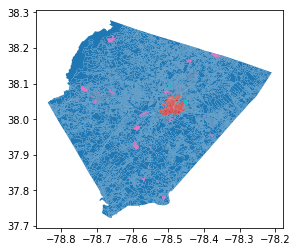

In [4]:
df.plot(column='location')

# join shapefiles

In [ ]:
# # links to Charlottesville Open Data portal
# baseurl = 'https://opendata.arcgis.com/datasets/'
# parcel_area_url = '320d465ddf0d498796da6491e21f6dde_43.geojson'
# parcel_area_detail_url = '0e9946c2a77d4fc6ad16d9968509c588_72.geojson'

## Get parcel data

The first step is to get parcel data, base and details, and merge them together

In [ ]:
# # get parcel data
# df = requests.get(baseurl + parcel_area_url).json()

# # convert to spatial dataframe
# df = gpd.GeoDataFrame.from_features(df)

# # add CRS so we can map
# df.crs = {'init' :'epsg:4326'}

# # lower column names
# df.columns = map(str.lower, df.columns)

In [ ]:
# # get parcel data
# df_detail = requests.get(baseurl + parcel_area_detail_url).json()

# # convert to spatial dataframe
# df_detail = gpd.GeoDataFrame.from_features(df_detail)

# # lower column names
# df_detail.columns = map(str.lower, df_detail.columns)

# # drop geometry
# df_detail.drop(['geometry','objectid'], axis=1,inplace=True)

In [ ]:
# df = df.merge(df_detail, on='gpin', how='left')

## Get fire incident data

Get fire incident data and convert to GeoDataFrame.

In [5]:
# read in fire incidents
fire = pd.read_csv(os.path.join(raw_dir, '12_16to5_18FireResponses-cleaner.csv'))

In [6]:
# remove empty lon/lat
fire.dropna(subset=['basic_incident_longitude_fd1_69','basic_incident_latitude_fd1_69'], inplace=True)

In [7]:
# make coordinates
fire['coordinates'] = list(zip(fire.basic_incident_longitude_fd1_69, fire.basic_incident_latitude_fd1_69))
fire['coordinates'] = fire['coordinates'].apply(shapely.geometry.Point)

# make geodataframe
fire = gpd.GeoDataFrame(fire, geometry='coordinates')
fire.crs = {'init' :'epsg:4326'}

In [ ]:
fire.shape

In [ ]:
fire.iloc[12,]

In [ ]:
base = df.plot(column='location')
fire.plot(ax=base, marker='*', color='green')

## Join fire incidents to parcels using lon/lat in polygons

Rather than trying to fuzzy match on address, see how well we can find the fire incident points in the parcel polygons.

In [39]:
geo_p = df[['geometry', 'GPIN']]
geo_f = fire[['coordinates','basic_incident_number_fd1']]

In [40]:
# join
cville_fires = gpd.sjoin(geo_f, geo_p, how='left')
cville_fires.shape

(325, 4)

In [41]:
cville_fires

,coordinates,basic_incident_number_fd1,index_right,GPIN
0,POINT (-78.500969 38.042275),2016-00006495,NaN,NaN
1,POINT (-78.50633000000001 38.009043),2016-00006520,43706.0,481062891000
2,POINT (-78.486643 38.02089),2016-00006545,56163.0,10934
3,POINT (-78.48701199999998 38.023539),2016-00006672,52154.0,9544
4,POINT (-78.47047499999999 38.03955),2017-00000106,NaN,NaN
5,POINT (-78.51757499999999 38.043244),2017-00000189,36160.0,477649903232
6,POINT (-78.485375 38.061426),2017-00000245,57623.0,542
7,POINT (-78.48599899999999 38.030561),2017-00000367,NaN,NaN
8,POINT (-78.462024 38.026901),2017-00000459,51251.0,8495
9,POINT (-78.52241500000001 38.02626),2017-00000460,NaN,NaN


In [42]:
# get missing
miss = cville_fires[cville_fires.index_right.isnull()]

In [36]:
miss

,coordinates,basic_incident_number_fd1,index_right,GPIN
0,POINT (-78.500969 38.042275),2016-00006495,NaN,NaN
4,POINT (-78.47047499999999 38.03955),2017-00000106,NaN,NaN
7,POINT (-78.48599899999999 38.030561),2017-00000367,NaN,NaN
9,POINT (-78.52241500000001 38.02626),2017-00000460,NaN,NaN
12,POINT (-78.499922 38.04038),2017-00000539,NaN,NaN
19,POINT (-78.46704200000001 38.03915900000001),2017-00000896,NaN,NaN
28,POINT (-78.48632099999999 38.028093),2017-00001484,NaN,NaN
29,POINT (-78.489975 38.059858),2017-00001485,NaN,NaN
38,POINT (-78.511561 38.042514),2017-00001802,NaN,NaN
43,POINT (-78.49117099999999 38.029744),2017-00001953,NaN,NaN


In [43]:
# drop geometry and convert to pandas data frame
cville_fires = pd.DataFrame(cville_fires.drop(columns=['coordinates','index_right']))

# add column of ones
cville_fires['fire'] = 1

# join back to parcel data frame
df = df.merge(cville_fires, how='left', on='GPIN')

# fill fire NaNs with 0, b/c that's what they are
df['fire'].fillna(0, inplace=True)

# merge in other fire information
df = df.merge(fire, how='left', on='basic_incident_number_fd1')


In [44]:
df

,GPIN,geometry,location,basic_incident_number_fd1,fire,basic_incident_date_original_fd1_3,basic_incident_latitude_fd1_69,basic_incident_longitude_fd1_69,basic_incident_type_fd1_21,basic_incident_type_code_and_description_fd1_21,basic_incident_type_subcategory_fd1_21,basic_incident_type_category_fd1_21,apparatus_resource_dispatch_date_time_fd18_3,basic_incident_psap_to_alarm_in_minutes,apparatus_resource_dispatch_to_en_route_in_minutes,apparatus_resource_en_route_to_arrived_in_minutes,apparatus_resource_vehicle_call_sign_list,apparatus_resource_arrival_date_time_fd18_4,coordinates
0,499588898989,"POLYGON ((-78.44202007775003 38.0311453699136,...",albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,499606898980,POLYGON ((-78.44195948675757 38.03111854548794...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,499629898965,POLYGON ((-78.44185144440901 38.03107071474042...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,499659898946,POLYGON ((-78.44174337031754 38.03102287036499...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,499682898929,"POLYGON ((-78.44168277838486 38.0309960457971,...",albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,499699898919,POLYGON ((-78.44162218763468 38.03096922119872...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,499717898909,POLYGON ((-78.44156159578836 38.03094239746967...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,499735898900,POLYGON ((-78.44150022521539 38.03091664091073...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,499755898881,POLYGON ((-78.44142095942125 38.03089588732156...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,499813898884,POLYGON ((-78.44137633694231 38.03089015542029...,albemarle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## TO DO

1. figure out why missing aren't joining